In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import AdamW, LBFGS
from torch import GradScaler
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
# One-qubit operators
sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.complex64)
sigma_y = torch.tensor([[0., -1j], [1j, 0.]], dtype=torch.complex64)
sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.complex64)
identity = torch.eye(2, dtype=torch.complex64)
# Two-qubit operators
# Qubit 1 controls
sx1 = torch.kron(sigma_x, identity)  # σₓ ⊗ I
sz1 = torch.kron(sigma_z, identity)  # σ_z ⊗ I
# Qubit 2 controls
sx2 = torch.kron(identity, sigma_x)  # I ⊗ σₓ
sz2 = torch.kron(identity, sigma_z)  # I ⊗ σ_z
# Coupling
szx = torch.kron(sigma_z, sigma_x)  # σ_z ⊗ σ_z

In [3]:
H_target = (1/np.sqrt(2)) * torch.tensor([[1., 1.], [1., -1.]], dtype=torch.complex64)
T_target = torch.tensor([[1., 0.], [0., np.exp(1j * np.pi / 4)]], dtype=torch.complex64)
CNOT_target = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=torch.complex64)

In [4]:
# System parameters
T_total = 1.0    # total time
N = 32           # number of time steps
dt = T_total / N # delta time
time_grid = torch.linspace(0, T_total, N)
K = 5
freqs = torch.linspace(1.0, 5.0, K)
omega0 = 2 * np.pi / T_total

In [5]:
# GRAPE
def propagate_grape(params, target):
  if target.shape[0] == 2:
    u_x = params['ux']
    u_z = params['uz']
    U = torch.eye(2, dtype=torch.complex64)
    for n in range(N):
      H = u_x[n] * sigma_x + u_z[n] * sigma_z
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  else:
    u1x = params['u1x']
    u1z = params['u1z']
    u2x = params['u2x']
    u2z = params['u2z']
    jzx = params['jzx']
    U = torch.eye(4, dtype=torch.complex64)
    for n in range(N):
      H = jzx[n] * szx + u1x[n] * sx1 + u1z[n] * sz1 + u2x[n] * sx2 + u2z[n] * sz2
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  return U

def process_fidelity_grape(U, U_target):
    dim = U_target.shape[0]
    fidelity = torch.clamp((torch.abs(torch.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = torch.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def loss_fn_grape(U, U_target):
    # Compute the global phase factor from the trace overlap
    trace_val = torch.trace(U_target.conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = torch.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = torch.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = U_target - U_aligned
    loss = torch.norm(diff, p='fro')**2
    return loss

def train_grape(iters, optimizer, params, target):
  scaler = GradScaler('cpu')
  loss_list, fid_list, inf_list = [], [], []
  for it in range(iters):
    optimizer.zero_grad(set_to_none=True)
    U = propagate_grape(params, target)
    loss = loss_fn_grape(U, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    fid, inf = process_fidelity_grape(U, target)
    loss_list.append(loss.item())
    fid_list.append(fid)
    inf_list.append(inf)
    if it % 100 == 0 or it == num_iters-1:
        print(f"Iteration {it}: Loss = {loss.item()}")
        print(f"Fidelity = {fid}, Infidelity = {inf}")
  return loss_list, fid_list, inf_list

In [6]:
# CRAB
def process_fidelity_crab(U, U_target):
    dim = U_target.shape[0]
    fidelity = np.clip((np.abs(np.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = np.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def drive_control(t, x):
    # x[0:K]: alpha coefficients, x[K:2K]: beta coefficients.
    alphas = x[:K]
    betas = x[K:2*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += alphas[k-1] * np.cos(k * omega0 * t) + betas[k-1] * np.sin(k * omega0 * t)
    return pulse

def detuning_control(t, x):
    # x[2K:3K]: gamma coefficients, x[3K:4K]: delta coefficients.
    gammas = x[2*K:3*K]
    deltas = x[3*K:4*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += gammas[k-1] * np.cos(k * omega0 * t) + deltas[k-1] * np.sin(k * omega0 * t)
    return pulse

# Total control pulse applied in the Hamiltonian.
# H(t) = εₓ(t) σ_x + ε_z(t) σ_z.
def hamiltonian(t, x):
    eps_x = drive_control(t, x)
    eps_z = detuning_control(t, x)
    return eps_x * sigma_x + eps_z * sigma_z

def propagate_crab(x):
  U = np.eye(2).copy()
  for t in time_grid:
    H = hamiltonian(t, x)
    U_step = expm(-1j * H * dt)
    U = U_step @ U
  return U

In [7]:
ux_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_adam, 'uz': uz_grape_h_adam}
optimizer = AdamW([ux_grape_h_adam, uz_grape_h_adam], lr=0.001, weight_decay=0.001)

In [8]:
num_iters = 3000
loss_list_grape_h_adam, fid_list_grape_h_adam, inf_list_grape_h_adam = train_grape(num_iters, optimizer, params, H_target)

Iteration 0: Loss = 3.9947049617767334
Fidelity = 1.752376078911766e-06, Infidelity = -7.506937436119188e-07
Iteration 100: Loss = 3.448124408721924
Fidelity = 0.01903535984456539, Infidelity = -0.008346637710928917
Iteration 200: Loss = 2.9185373783111572
Fidelity = 0.07309747487306595, Infidelity = -0.03296593204140663
Iteration 300: Loss = 2.4216747283935547
Fidelity = 0.1556941270828247, Infidelity = -0.07350018620491028
Iteration 400: Loss = 1.9699349403381348
Fidelity = 0.25757288932800293, Infidelity = -0.12934617698192596
Iteration 500: Loss = 1.5715410709381104
Fidelity = 0.3685883581638336, Infidelity = -0.1996873915195465
Iteration 600: Loss = 1.2303680181503296
Fidelity = 0.4794289469718933, Infidelity = -0.283519983291626
Iteration 700: Loss = 0.9463073015213013
Fidelity = 0.582814633846283, Infidelity = -0.3796709477901459
Iteration 800: Loss = 0.7160404920578003
Fidelity = 0.6740244030952454, Infidelity = -0.4868149161338806
Iteration 900: Loss = 0.5340003967285156
Fidel

In [9]:
ux_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_lbfgs, 'uz': uz_grape_h_lbfgs}

loss_list_grape_h_lbfgs, fid_list_grape_h_lbfgs, inf_list_grape_h_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, H_target)
  loss = loss_fn_grape(U, H_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, H_target)
  loss_list_grape_h_lbfgs.append(loss.item())
  fid_list_grape_h_lbfgs.append(fid)
  inf_list_grape_h_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_h_lbfgs , uz_grape_h_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_h_lbfgs[-1]}, Infidelity: {inf_list_grape_h_lbfgs[-1]}")

Iteration 0, Loss: 3.9206371307373047
Fidelity: 0.039151955395936966, Infidelity: -0.01734529435634613
Iteration 10, Loss: 1.4611425399780273
Fidelity: 0.5593219995498657, Infidelity: -0.355878621339798
Iteration 20, Loss: 0.4996751546859741
Fidelity: 0.7766403555870056, Infidelity: -0.6509953141212463
Iteration 30, Loss: 0.23507870733737946
Fidelity: 0.892370343208313, Infidelity: -0.9680680632591248
Iteration 40, Loss: 0.12106402218341827
Fidelity: 0.9443463087081909, Infidelity: -1.25450599193573
Iteration 50, Loss: 0.059576090425252914
Fidelity: 0.9719250798225403, Infidelity: -1.5516815185546875
Iteration 60, Loss: 0.027842970564961433
Fidelity: 0.9874802827835083, Infidelity: -1.9024055004119873
Iteration 70, Loss: 0.011776176281273365
Fidelity: 0.9945369958877563, Infidelity: -2.262568473815918
Iteration 80, Loss: 0.005190085619688034
Fidelity: 0.9976027011871338, Infidelity: -2.6202778816223145
Iteration 90, Loss: 0.002621208783239126
Fidelity: 0.9987705945968628, Infidelity: -

In [10]:
loss_list_crab_h, fid_list_crab_h, inf_list_crab_h = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(H_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = H_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_h.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, H_target.numpy())
    fid_list_crab_h.append(fid)
    inf_list_crab_h.append(inf)
    return loss

In [11]:
x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_198144/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 837
         Function evaluations: 1216


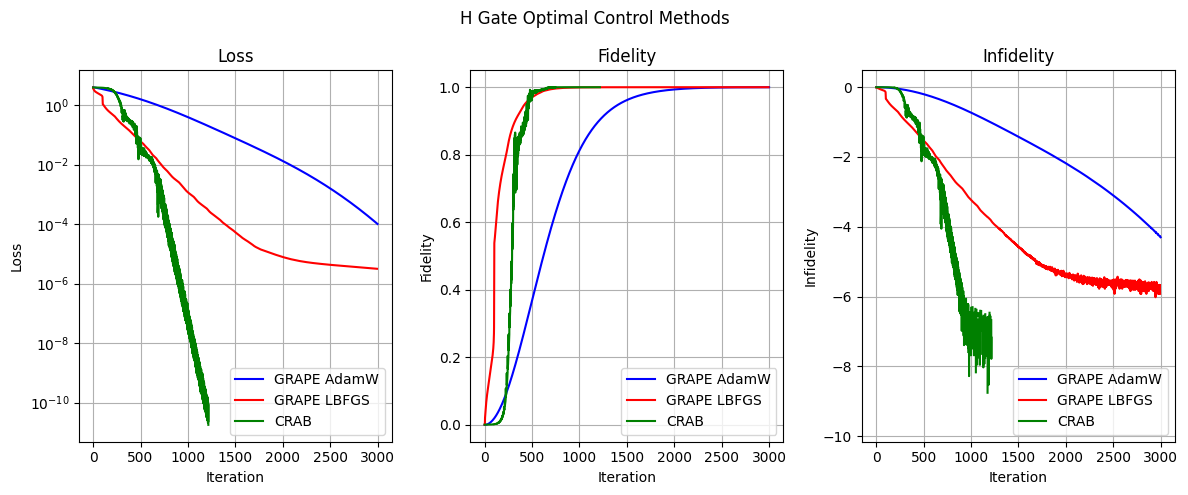

In [12]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle("H Gate Optimal Control Methods")
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_h, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_h, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_h, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Methods.png"
)
plt.tight_layout()
plt.show()

In [13]:
pd.DataFrame({'loss_grape_h_adam': loss_list_grape_h_adam, 'fid_grape_h_adam': fid_list_grape_h_adam, 'inf_grape_h_adam': inf_list_grape_h_adam}).to_csv('grape_h_adam.csv')
pd.DataFrame({'loss_grape_h_lbfgs': loss_list_grape_h_lbfgs, 'fid_grape_h_lbfgs': fid_list_grape_h_lbfgs, 'inf_grape_h_lbfgs': inf_list_grape_h_lbfgs}).to_csv('grape_h_lbfgs.csv')
pd.DataFrame({'loss_crab_h': loss_list_crab_h, 'fid_crab_h': fid_list_crab_h, 'inf_crab_h': inf_list_crab_h}).to_csv('crab_h.csv')

In [14]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_h_adam = ux_grape_h_adam.detach().cpu().numpy()
uz_grape_h_adam = uz_grape_h_adam.detach().cpu().numpy()
ux_grape_h_lbfgs = ux_grape_h_lbfgs.detach().cpu().numpy()
uz_grape_h_lbfgs = uz_grape_h_lbfgs.detach().cpu().numpy()

x_opt = res.x
ux_grape_h_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_h_crab = [detuning_control(t, x_opt) for t in time_grid]

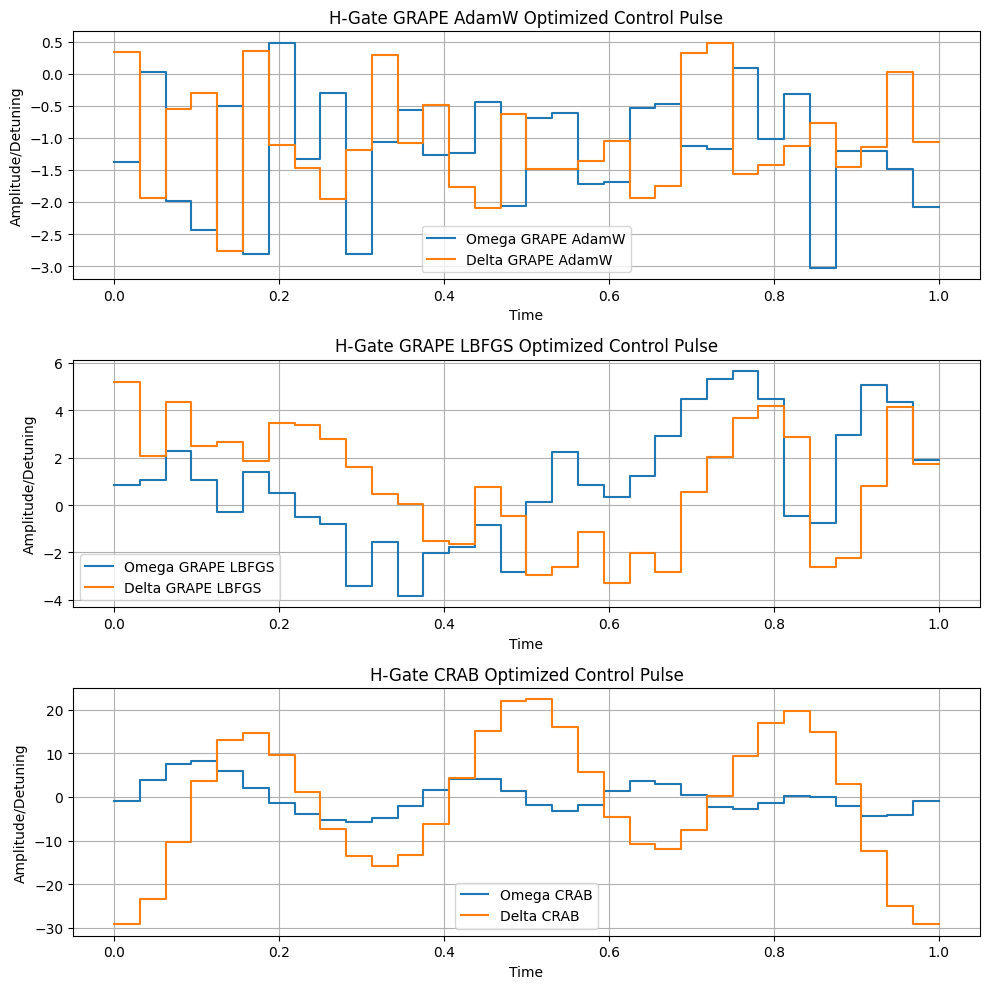

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_h_adam, ux_grape_h_adam[-1]), where='post', label='Omega GRAPE AdamW')
plt.step(time_edges, np.append(uz_grape_h_adam, uz_grape_h_adam[-1]), where='post', label='Delta GRAPE AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_h_lbfgs, ux_grape_h_lbfgs[-1]), where='post', label='Omega GRAPE LBFGS')
plt.step(time_edges, np.append(uz_grape_h_lbfgs, uz_grape_h_lbfgs[-1]), where='post', label='Delta GRAPE LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_h_crab, ux_grape_h_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_h_crab, uz_grape_h_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Pulses.png"
)
plt.show()

In [16]:
# T-Gate
ux_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_adam, 'uz': uz_grape_t_adam}
optimizer = AdamW([ux_grape_t_adam, uz_grape_t_adam], lr=0.001, weight_decay=0.001)

In [17]:
num_iters = 1200
loss_list_grape_t_adam, fid_list_grape_t_adam, inf_list_grape_t_adam = train_grape(num_iters, optimizer, params, T_target)

Iteration 0: Loss = 0.6816988587379456
Fidelity = 0.6881945729255676, Infidelity = -0.5061163306236267
Iteration 100: Loss = 0.47676771879196167
Fidelity = 0.7758232355117798, Infidelity = -0.6494094133377075
Iteration 200: Loss = 0.3224177360534668
Fidelity = 0.8452876806259155, Infidelity = -0.8104751110076904
Iteration 300: Loss = 0.20891588926315308
Fidelity = 0.8982700109481812, Infidelity = -0.9925510287284851
Iteration 400: Loss = 0.1291865110397339
Fidelity = 0.936449408531189, Infidelity = -1.1968804597854614
Iteration 500: Loss = 0.07590069621801376
Fidelity = 0.9624095559120178, Infidelity = -1.4249225854873657
Iteration 600: Loss = 0.04218832403421402
Fidelity = 0.9790170192718506, Infidelity = -1.6781327724456787
Iteration 700: Loss = 0.022099725902080536
Fidelity = 0.9889808893203735, Infidelity = -1.9578534364700317
Iteration 800: Loss = 0.010873472318053246
Fidelity = 0.9945704936981201, Infidelity = -2.265239715576172
Iteration 900: Loss = 0.005010075401514769
Fidelity

In [18]:
ux_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_lbfgs, 'uz': uz_grape_t_lbfgs}

loss_list_grape_t_lbfgs, fid_list_grape_t_lbfgs, inf_list_grape_t_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, T_target)
  loss = loss_fn_grape(U, T_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, T_target)
  loss_list_grape_t_lbfgs.append(loss.item())
  fid_list_grape_t_lbfgs.append(fid)
  inf_list_grape_t_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_t_lbfgs , uz_grape_t_lbfgs], lr=0.001, max_iter=10)

num_iterations = 120
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_t_lbfgs[-1]}, Infidelity: {inf_list_grape_t_lbfgs[-1]}")

Iteration 0, Loss: 0.23290032148361206
Fidelity: 0.8887359499931335, Infidelity: -0.9536451101303101
Iteration 10, Loss: 0.18194854259490967
Fidelity: 0.9135158061981201, Infidelity: -1.0630632638931274
Iteration 20, Loss: 0.1330747753381729
Fidelity: 0.9363455772399902, Infidelity: -1.1961714029312134
Iteration 30, Loss: 0.08942614495754242
Fidelity: 0.958444356918335, Infidelity: -1.381369948387146
Iteration 40, Loss: 0.04080335423350334
Fidelity: 0.9808300733566284, Infidelity: -1.7173795700073242
Iteration 50, Loss: 0.021430980414152145
Fidelity: 0.9898889660835266, Infidelity: -1.9952044486999512
Iteration 60, Loss: 0.01223234087228775
Fidelity: 0.9941891431808472, Infidelity: -2.235759735107422
Iteration 70, Loss: 0.007150523364543915
Fidelity: 0.9965866208076477, Infidelity: -2.46681547164917
Iteration 80, Loss: 0.0043154191225767136
Fidelity: 0.9979391098022461, Infidelity: -2.6859450340270996
Iteration 90, Loss: 0.002652770606800914
Fidelity: 0.9987297654151917, Infidelity: -2

In [19]:
loss_list_crab_t, fid_list_crab_t, inf_list_crab_t = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(T_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = T_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_t.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, T_target.numpy())
    fid_list_crab_t.append(fid)
    inf_list_crab_t.append(inf)
    return loss

x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_198144/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 703
         Function evaluations: 1049


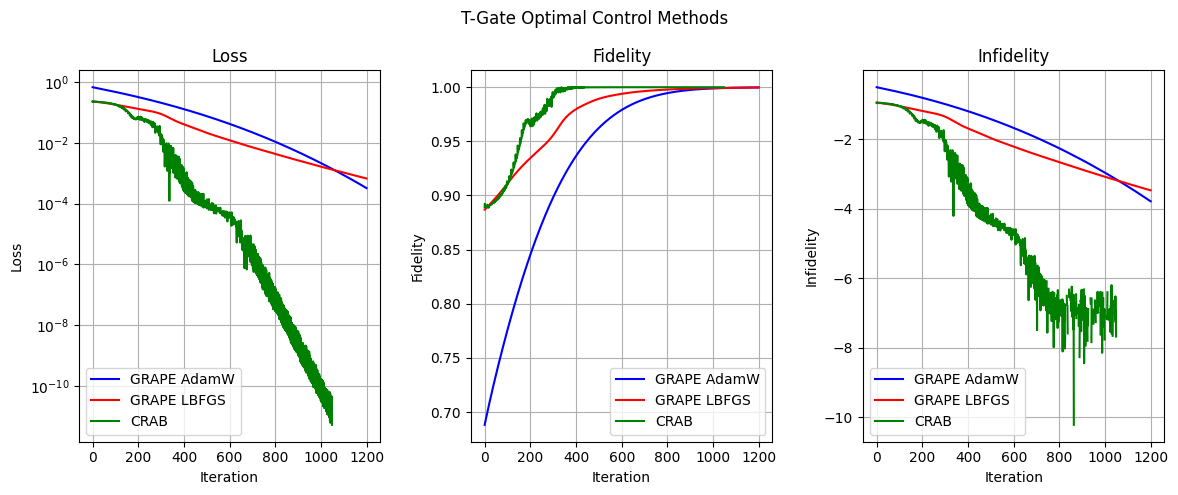

In [20]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('T-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_t, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_t, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_t, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Methods.png')
plt.show()

In [21]:
pd.DataFrame({'loss_grape_t_adam': loss_list_grape_t_adam, 'fid_grape_t_adam': fid_list_grape_t_adam, 'inf_grape_t_adam': inf_list_grape_t_adam}).to_csv('grape_t_adam.csv')
pd.DataFrame({'loss_grape_t_lbfgs': loss_list_grape_t_lbfgs, 'fid_grape_t_lbfgs': fid_list_grape_t_lbfgs, 'inf_grape_t_lbfgs': inf_list_grape_t_lbfgs}).to_csv('grape_t_lbfgs.csv')
pd.DataFrame({'loss_crab_t': loss_list_crab_t, 'fid_crab_t': fid_list_crab_t, 'inf_crab_t': inf_list_crab_t}).to_csv('crab_t.csv')

In [22]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_t_adam = ux_grape_t_adam.detach().cpu().numpy()
uz_grape_t_adam = uz_grape_t_adam.detach().cpu().numpy()
ux_grape_t_lbfgs = ux_grape_t_lbfgs.detach().cpu().numpy()
uz_grape_t_lbfgs = uz_grape_t_lbfgs.detach().cpu().numpy()
x_opt = res.x
ux_grape_t_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_t_crab = [detuning_control(t, x_opt) for t in time_grid]

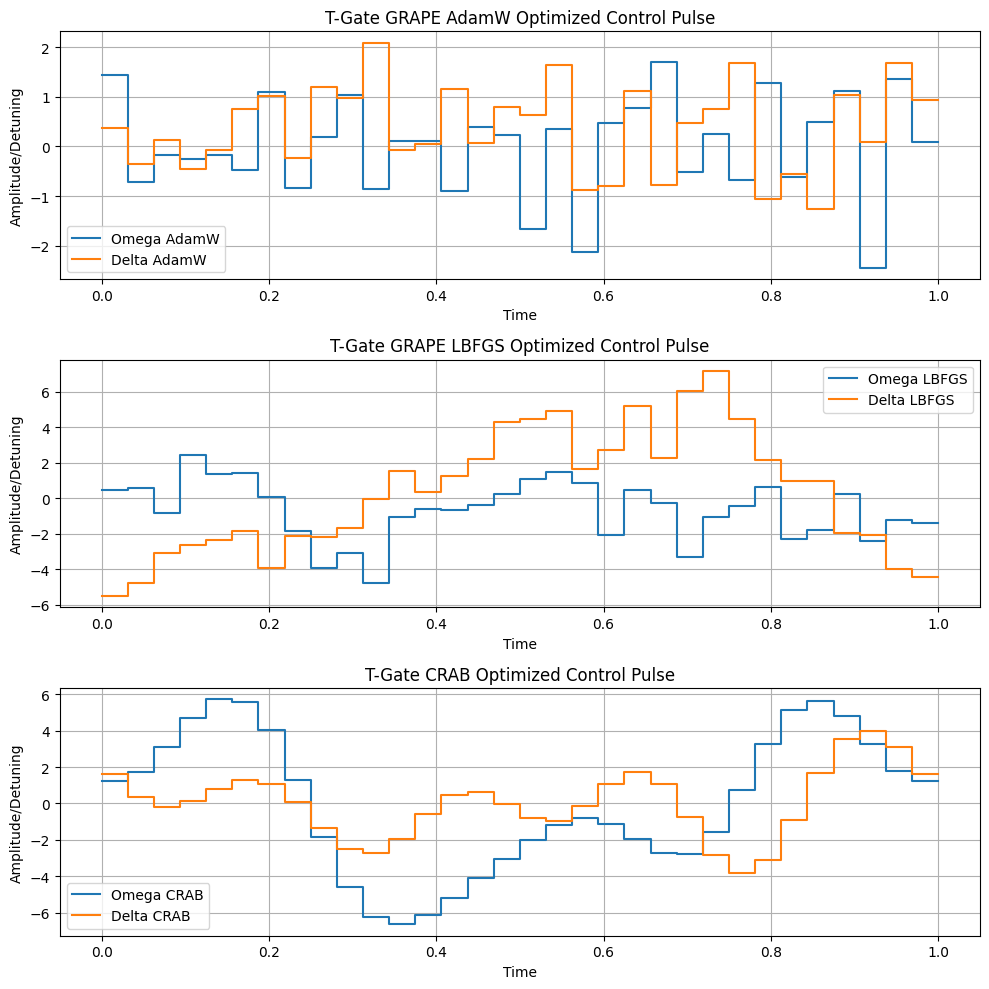

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_t_adam, ux_grape_t_adam[-1]), where='post', label='Omega AdamW')
plt.step(time_edges, np.append(uz_grape_t_adam, uz_grape_t_adam[-1]), where='post', label='Delta AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_t_lbfgs, ux_grape_t_lbfgs[-1]), where='post', label='Omega LBFGS')
plt.step(time_edges, np.append(uz_grape_t_lbfgs, uz_grape_t_lbfgs[-1]), where='post', label='Delta LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_t_crab, ux_grape_t_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_t_crab, uz_grape_t_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Pulses.png')
plt.show()

In [24]:
u1x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_adam, 'u1z': u1z_grape_cnot_adam, 'u2x': u2x_grape_cnot_adam, 'u2z': u2z_grape_cnot_adam, 'jzx': jzx_grape_cnot_adam}
optimizer = AdamW([u1x_grape_cnot_adam, u1z_grape_cnot_adam, u2x_grape_cnot_adam, u2z_grape_cnot_adam, jzx_grape_cnot_adam], lr=0.001, weight_decay=0.001)

In [25]:
num_iters = 3000
loss_list_grape_cnot_adam, fid_list_grape_cnot_adam, inf_list_grape_cnot_adam = train_grape(num_iters, optimizer, params, CNOT_target)

Iteration 0: Loss = 3.0849459171295166
Fidelity = 0.37746497988700867, Infidelity = -0.2058362364768982
Iteration 100: Loss = 2.223494529724121
Fidelity = 0.521375298500061, Infidelity = -0.3200048804283142
Iteration 200: Loss = 1.4660508632659912
Fidelity = 0.6670701503753662, Infidelity = -0.4776472747325897
Iteration 300: Loss = 0.8876597285270691
Fidelity = 0.7903961539268494, Infidelity = -0.6786007285118103
Iteration 400: Loss = 0.4968785047531128
Fidelity = 0.8796378374099731, Infidelity = -0.919510006904602
Iteration 500: Loss = 0.25910139083862305
Fidelity = 0.9362736344337463, Infidelity = -1.195680856704712
Iteration 600: Loss = 0.12642966210842133
Fidelity = 0.9686421155929565, Infidelity = -1.5036532878875732
Iteration 700: Loss = 0.057864729315042496
Fidelity = 0.9855859279632568, Infidelity = -1.841213345527649
Iteration 800: Loss = 0.024964921176433563
Fidelity = 0.9937685132026672, Infidelity = -2.2054083347320557
Iteration 900: Loss = 0.010311488062143326
Fidelity = 0

In [26]:
u1x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_lbfgs, 'u1z': u1z_grape_cnot_lbfgs, 'u2x': u2x_grape_cnot_lbfgs, 'u2z': u2z_grape_cnot_lbfgs, 'jzx': jzx_grape_cnot_lbfgs}

loss_list_cnot_grape_lbfgs, fid_list_cnot_grape_lbfgs, inf_list_cnot_grape_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, CNOT_target)
  loss = loss_fn_grape(U, CNOT_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, CNOT_target)
  loss_list_cnot_grape_lbfgs.append(loss.item())
  fid_list_cnot_grape_lbfgs.append(fid)
  inf_list_cnot_grape_lbfgs.append(inf)
  return loss

optimizer = LBFGS([u1x_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs, jzx_grape_cnot_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_cnot_grape_lbfgs[-1]}, Infidelity: {inf_list_cnot_grape_lbfgs[-1]}")

Iteration 0, Loss: 3.962240219116211
Fidelity: 0.25512516498565674, Infidelity: -0.12791669368743896
Iteration 10, Loss: 3.9248690605163574
Fidelity: 0.25991952419281006, Infidelity: -0.1307210475206375
Iteration 20, Loss: 3.8858461380004883
Fidelity: 0.26493313908576965, Infidelity: -0.13367313146591187
Iteration 30, Loss: 3.8453941345214844
Fidelity: 0.2701816260814667, Infidelity: -0.13678522408008575
Iteration 40, Loss: 3.8034369945526123
Fidelity: 0.27567949891090393, Infidelity: -0.14006920158863068
Iteration 50, Loss: 3.7599129676818848
Fidelity: 0.2814410626888275, Infidelity: -0.14353762567043304
Iteration 60, Loss: 3.714769124984741
Fidelity: 0.28748011589050293, Infidelity: -0.1472030133008957
Iteration 70, Loss: 3.667964458465576
Fidelity: 0.29380863904953003, Infidelity: -0.15107759833335876
Iteration 80, Loss: 3.6194732189178467
Fidelity: 0.3004375696182251, Infidelity: -0.15517352521419525
Iteration 90, Loss: 3.569277048110962
Fidelity: 0.30737656354904175, Infidelity: -

In [27]:
num_channels = 5   # drive, detuning, coupling.
N_params = num_channels * (2 * K)

loss_list_crab_cnot, fid_list_crab_cnot, inf_list_crab_cnot = [], [], []

# Function to construct a control pulse at time t given Fourier coefficients.
def control_pulse(t, coeffs):
    # coeffs is a vector of length 2*K.
    val = 0.0
    for k in range(1, K+1):
        alpha = coeffs[k-1]
        beta  = coeffs[K + k - 1]
        val += alpha * np.cos(k * omega0 * t) + beta * np.sin(k * omega0 * t)
    return val

# Full Hamiltonian at time t, given control parameters x.
def H_total(t, x):
    # Channel 1: drive1 (first 2*K coefficients)
    # Channel 2: detuning1 (next 2*K)
    # Channel 3: drive2 (next 2*K)
    # Channel 4: detuning2 (next 2*K)
    # Channel 5: coupling (last 2*K)
    coeff_drive1    = x[0:2*K]
    coeff_detuning1 = x[2*K:4*K]
    coeff_drive2    = x[4*K:6*K]
    coeff_detuning2 = x[6*K:8*K]
    coeff_coupling  = x[8*K:10*K]

    eps_drive1    = control_pulse(t, coeff_drive1)
    eps_detuning1 = control_pulse(t, coeff_detuning1)
    eps_drive2    = control_pulse(t, coeff_drive2)
    eps_detuning2 = control_pulse(t, coeff_detuning2)
    eps_coupling  = control_pulse(t, coeff_coupling)

    H = (eps_drive1 * sx1 +
         eps_detuning1 * sz1 +
         eps_drive2 * sx2+
         eps_detuning2 * sz2 +
         eps_coupling * szx)
    return H

def propagate_crab(x):
    U = np.eye(4, dtype=complex)
    for t in time_grid:
        H = H_total(t, x)
        U_step = expm(-1j * H * dt)
        U = U_step @ U
    return U

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(CNOT_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = CNOT_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_cnot.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, CNOT_target.numpy())
    fid_list_crab_cnot.append(fid)
    inf_list_crab_cnot.append(inf)
    return loss

x0 = np.random.randn(N_params)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_198144/155260203.py:68: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.


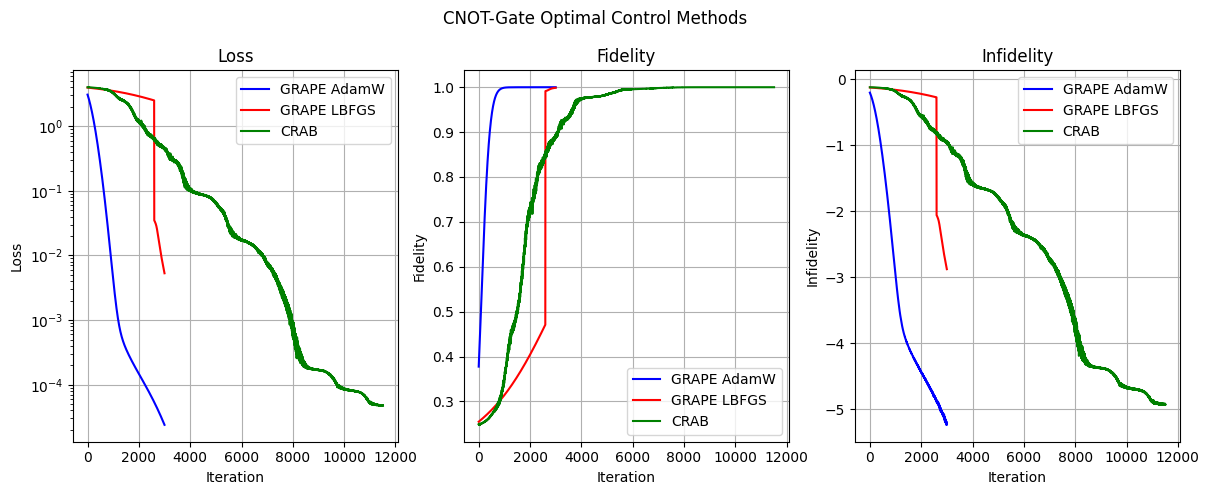

In [34]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('CNOT-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_cnot, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_cnot, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_cnot, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/PlotsCNOT-Gate Optimal Control Methods.png')
plt.show()

In [29]:
pd.DataFrame({'loss_grape_cnot_adam': loss_list_grape_cnot_adam, 'fid_grape_cnot_adam': fid_list_grape_cnot_adam, 'inf_grape_cnot_adam': inf_list_grape_cnot_adam}).to_csv('grape_cnot_adam.csv')
pd.DataFrame({'loss_grape_cnot_lbfgs': loss_list_cnot_grape_lbfgs, 'fid_grape_cnot_lbfgs': fid_list_cnot_grape_lbfgs, 'inf_grape_cnot_lbfgs': inf_list_cnot_grape_lbfgs}).to_csv('grape_cnot_lbfgs.csv')
pd.DataFrame({'loss_crab_cnot': loss_list_crab_cnot, 'fid_crab_cnot': fid_list_crab_cnot, 'inf_crab_cnot': inf_list_crab_cnot}).to_csv('crab_cnot.csv')

In [30]:
u1x_grape_cnot_adam = u1x_grape_cnot_adam.detach().cpu().numpy()
u1z_grape_cnot_adam = u1z_grape_cnot_adam.detach().cpu().numpy()
u2x_grape_cnot_adam = u2x_grape_cnot_adam.detach().cpu().numpy()
u2z_grape_cnot_adam = u2z_grape_cnot_adam.detach().cpu().numpy()
coup_str_adam = jzx_grape_cnot_adam.detach().cpu().numpy()

u1x_grape_cnot_lbfgs = u1x_grape_cnot_lbfgs.detach().cpu().numpy()
u1z_grape_cnot_lbfgs = u1z_grape_cnot_lbfgs.detach().cpu().numpy()
u2x_grape_cnot_lbfgs = u2x_grape_cnot_lbfgs.detach().cpu().numpy()
u2z_grape_cnot_lbfgs = u2z_grape_cnot_lbfgs.detach().cpu().numpy()
coup_str_lbfgs = jzx_grape_cnot_lbfgs.detach().cpu().numpy()

In [31]:
coeff_drive1_opt    = res.x[0:2*K]
coeff_detuning1_opt = res.x[2*K:4*K]
coeff_drive2_opt    = res.x[4*K:6*K]
coeff_detuning2_opt = res.x[6*K:8*K]
coeff_coupling_opt = res.x[8*K:10*K]
time_edges = np.linspace(0, T_total, N+1)
u1x_crab_cnot = np.array([control_pulse(t, coeff_drive1_opt) for t in time_grid])
u1z_crab_cnot = np.array([control_pulse(t, coeff_detuning1_opt) for t in time_grid])
u2x_crab_cnot = np.array([control_pulse(t, coeff_drive2_opt) for t in time_grid])
u2z_crab_cnot = np.array([control_pulse(t, coeff_detuning2_opt) for t in time_grid])
coup_str_crab = np.array([control_pulse(t, coeff_coupling_opt) for t in time_grid])

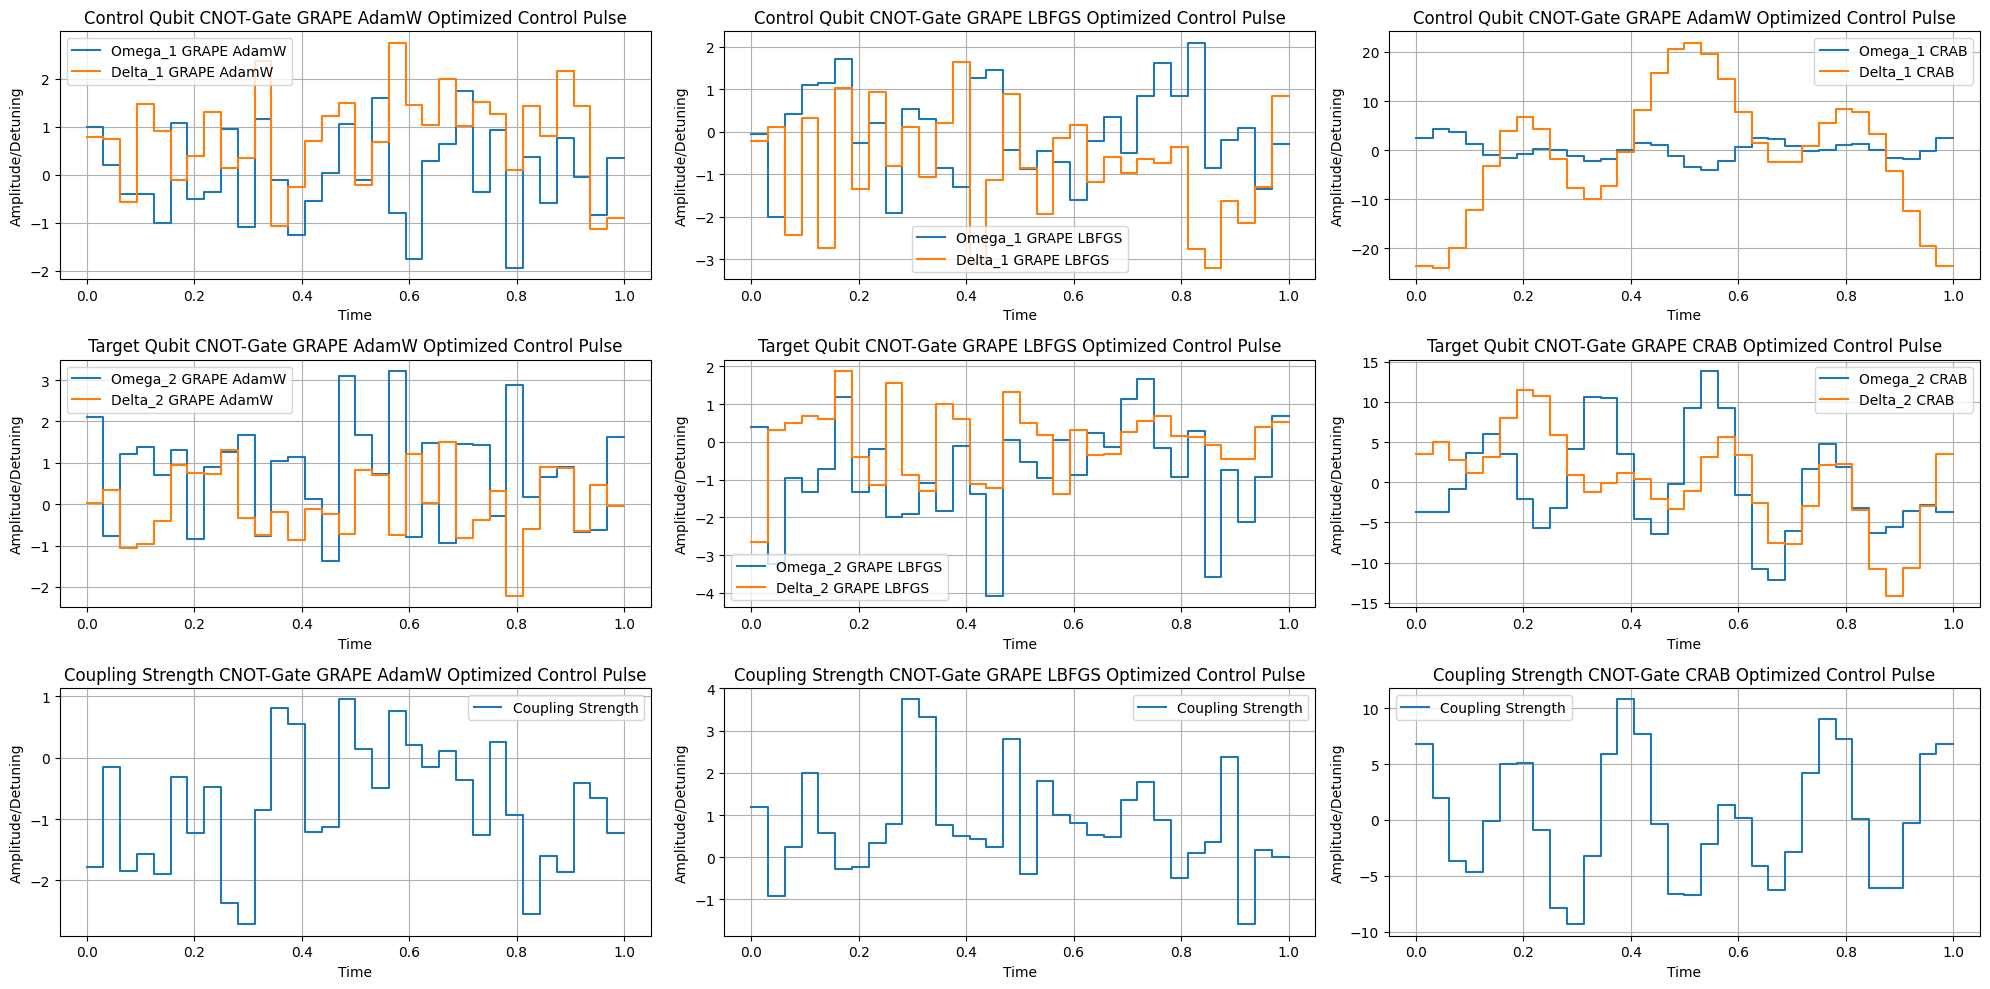

In [32]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 3, 1)
plt.step(time_edges, np.append(u1x_grape_cnot_adam, u1x_grape_cnot_adam[-1]), where='post', label="Omega_1 GRAPE AdamW")
plt.step(time_edges, np.append(u1z_grape_cnot_adam, u1z_grape_cnot_adam[-1]), where='post', label="Delta_1 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 2)
plt.step(time_edges, np.append(u1x_grape_cnot_lbfgs, u1x_grape_cnot_lbfgs[-1]), where='post', label="Omega_1 GRAPE LBFGS")
plt.step(time_edges, np.append(u1z_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs[-1]), where='post', label="Delta_1 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 3)
plt.step(time_edges, np.append(u1x_crab_cnot, u1x_crab_cnot[-1]), where='post', label="Omega_1 CRAB")
plt.step(time_edges, np.append(u1z_crab_cnot, u1z_crab_cnot[-1]), where='post', label="Delta_1 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 4)
plt.step(time_edges, np.append(u2x_grape_cnot_adam, u2x_grape_cnot_adam[-1]), where='post', label="Omega_2 GRAPE AdamW")
plt.step(time_edges, np.append(u2z_grape_cnot_adam, u2z_grape_cnot_adam[-1]), where='post', label="Delta_2 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 5)
plt.step(time_edges, np.append(u2x_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs[-1]), where='post', label="Omega_2 GRAPE LBFGS")
plt.step(time_edges, np.append(u2z_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs[-1]), where='post', label="Delta_2 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 6)
plt.step(time_edges, np.append(u2x_crab_cnot, u2x_crab_cnot[-1]), where='post', label="Omega_2 CRAB")
plt.step(time_edges, np.append(u2z_crab_cnot, u2z_crab_cnot[-1]), where='post', label="Delta_2 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 7)
plt.step(time_edges, np.append(coup_str_adam, coup_str_adam[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 8)
plt.step(time_edges, np.append(coup_str_lbfgs, coup_str_lbfgs[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 9)
plt.step(time_edges, np.append(coup_str_crab, coup_str_crab[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses.png')
plt.show()